In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

print(len(counts))
print(len(weather))
print(counts[:5])
print(weather[:5])

C:\Users\chris\AppData\Local\Temp\ipykernel_335880\739794661.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)


61296
1340
                     Fremont Bridge East Sidewalk  \
Date                                                
2019-01-01 00:00:00                           0.0   
2019-01-01 01:00:00                           2.0   
2019-01-01 02:00:00                           1.0   
2019-01-01 03:00:00                           1.0   
2019-01-01 04:00:00                           2.0   

                     Fremont Bridge West Sidewalk  
Date                                               
2019-01-01 00:00:00                           9.0  
2019-01-01 01:00:00                          22.0  
2019-01-01 02:00:00                          11.0  
2019-01-01 03:00:00                           2.0  
2019-01-01 04:00:00                           1.0  
                      STATION                                STATION_NAME  \
DATE                                                                        
2012-01-01  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-02  GHCND:USW0

In [3]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
print(daily[:5])

             Total
Date              
2012-10-03  3521.0
2012-10-04  3475.0
2012-10-05  3148.0
2012-10-06  2006.0
2012-10-07  2142.0


In [4]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
print(daily[:5])

# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun
Date                                                 
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday
Date                                                          
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0


C:\Users\chris\AppData\Local\Temp\ipykernel_335880\921517219.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily['holiday'].fillna(0, inplace=True)


             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs
Date                                                                        
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     11.045208


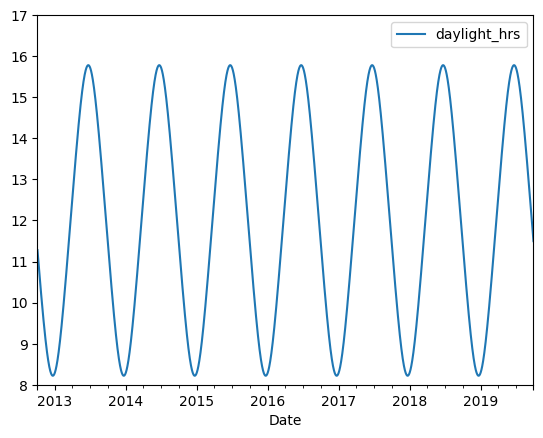

In [5]:
# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.Timestamp(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

print(daily[:5])

In [6]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

daily[:5]

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Total,1.000000,0.147496,0.200247,0.186168,0.142324,0.054430,-0.360151,-0.370513,-0.111138,0.619645,-0.465832,0.620759,0.429007,0.235085,0.932395
Mon,0.147496,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,0.195584,0.000398,-0.025984,0.019147,0.017129,0.002658,0.143697
Tue,0.200247,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.018851,0.000651,0.006232,0.004420,-0.010122,0.003987,0.212646
Wed,0.186168,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.035347,-0.000582,0.005944,-0.011469,0.000779,-0.003987,0.197020
Thu,0.142324,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,0.030634,-0.000407,0.010861,-0.001675,-0.015572,-0.002658,0.140759
Fri,0.054430,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.035347,-0.000240,0.026654,0.000109,-0.037373,-0.001329,0.033788
Sat,-0.360151,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.068337,-0.000044,-0.017684,-0.005938,0.028030,0.000000,-0.356990
Sun,-0.370513,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.068337,0.000223,-0.006022,-0.004595,0.017129,0.001329,-0.370920
holiday,-0.111138,0.195584,-0.018851,-0.035347,0.030634,-0.035347,-0.068337,-0.068337,1.000000,-0.078683,-0.050033,-0.068670,0.059115,-0.027033,-0.130353
daylight_hrs,0.619645,0.000398,0.000651,-0.000582,-0.000407,-0.000240,-0.000044,0.000223,-0.078683,1.000000,-0.309827,0.790928,0.307485,0.251385,0.686756


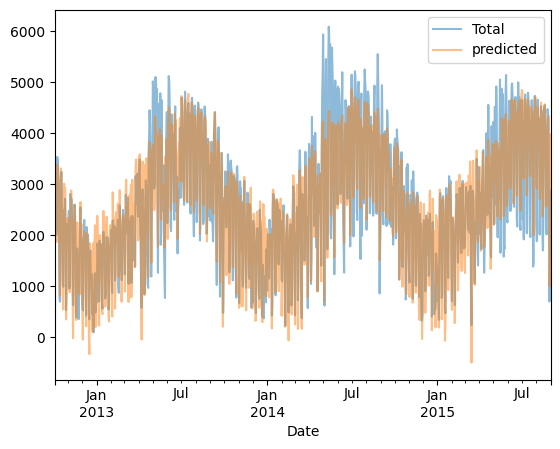

In [7]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

daily.head()

# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

# a little bit different than our previous example
# this plot is from pandas
daily[['Total', 'predicted']].plot(alpha=0.5);

# the estimated beta0 to betan
params = pd.Series(model.coef_, index=X.columns)
params


import matplotlib.pyplot as plt
daily[:5]
daily.corr(method='spearman')

This is where our HW Code begins

In [8]:
# Define feature columns and target
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

# Initialize models
linear_model = LinearRegression()
lasso_model = make_pipeline(StandardScaler(), Lasso())
ridge_model = make_pipeline(StandardScaler(), Ridge())

In [9]:
# Set up parameter grid for RandomizedSearchCV
lasso_param_grid = {'lasso__alpha': np.logspace(-3, 3, 7)}
ridge_param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}

# RandomizedSearchCV for Lasso
lasso_search = RandomizedSearchCV(lasso_model, lasso_param_grid, n_iter=10, cv=10, random_state=42)
lasso_search.fit(X, y)
lasso_cv_scores = cross_val_score(lasso_search.best_estimator_, X, y, cv=10)

# RandomizedSearchCV for Ridge
ridge_search = RandomizedSearchCV(ridge_model, ridge_param_grid, n_iter=10, cv=10, random_state=42)
ridge_search.fit(X, y)
ridge_cv_scores = cross_val_score(ridge_search.best_estimator_, X, y, cv=10)

c:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e+06, tolerance: 1.476e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.555e+06, tolerance: 1.544e+05
  model = cd

In [10]:
# Evaluate Linear Regression with 10-fold CV
linear_cv_scores = cross_val_score(linear_model, X, y, cv=10)

# Collect results
results = {
    'Model': ['Linear Regression', 'Lasso', 'Ridge'],
    'Mean CV Score': [linear_cv_scores.mean(), lasso_cv_scores.mean(), ridge_cv_scores.mean()],
    'Best Alpha (if applied)': [None, lasso_search.best_params_['lasso__alpha'], ridge_search.best_params_['ridge__alpha']]
}

results_df = pd.DataFrame(results)

In [11]:
# Display results
print(results_df)

# Determine the best model
best_model = results_df.loc[results_df['Mean CV Score'].idxmax()]
print(f"Best Model: {best_model['Model']} with a score of {best_model['Mean CV Score']:.2f}")

               Model  Mean CV Score  Best Alpha (if applied)
0  Linear Regression       0.769175                      NaN
1              Lasso       0.771242                     10.0
2              Ridge       0.773031                    100.0
Best Model: Ridge with a score of 0.77


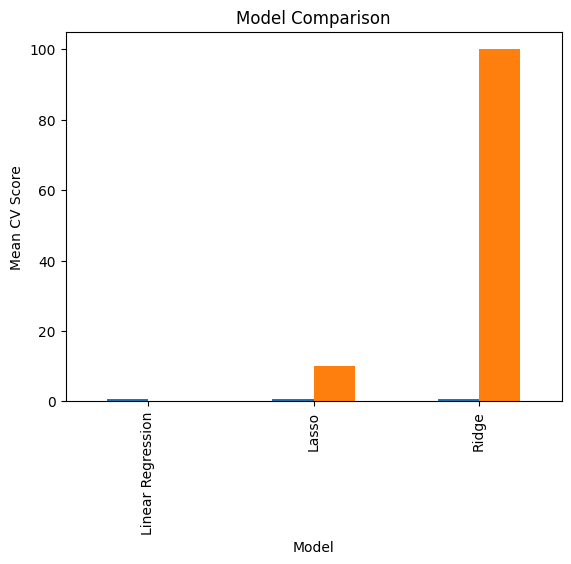

In [12]:
# Optional: Visualize results
results_df.set_index('Model').plot(kind='bar', legend=False)
plt.ylabel('Mean CV Score')
plt.title('Model Comparison')
plt.show()